# Analyse des Performances - Application de Palettes de Couleurs

Ce notebook analyse les performances de notre application de palettes de couleurs, en se concentrant sur :
1. Les métriques de performance système
2. Les temps de réponse
3. L'analyse de l'algorithme de sélection
4. La complexité algorithmique

In [1]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import requests
import time
from datetime import datetime, timedelta

## 1. Métriques de Performance Système

Nous allons mesurer :
- Utilisation CPU
- Utilisation mémoire
- Temps de réponse API

In [2]:
def collect_system_metrics(duration_seconds=300, interval=1):
    metrics = []
    start_time = time.time()
    end_time = start_time + duration_seconds
    
    while time.time() < end_time:
        # Mesure des métriques système
        cpu_percent = psutil.cpu_percent()
        memory_percent = psutil.virtual_memory().percent
        
        # Mesure du temps de réponse de l'API
        try:
            start_request = time.time()
            response = requests.get('http://localhost:5003/api/palettes')
            end_request = time.time()
            api_response_time = (end_request - start_request) * 1000  # Conversion en millisecondes
            
            metrics.append({
                'timestamp': datetime.datetime.now(),
                'cpu_percent': cpu_percent,
                'memory_percent': memory_percent,
                'api_response_time': api_response_time
            })
            
        except requests.exceptions.RequestException as e:
            print(f"Erreur lors de la requête API: {e}")
            
        time.sleep(interval)
    
    return pd.DataFrame(metrics)

In [3]:
# Collecte des métriques pendant 5 minutes
print("Collecte des métriques en cours...")
df_metrics = collect_system_metrics()
print("Collecte terminée !")

Collecte des métriques en cours...
Collecte terminée !


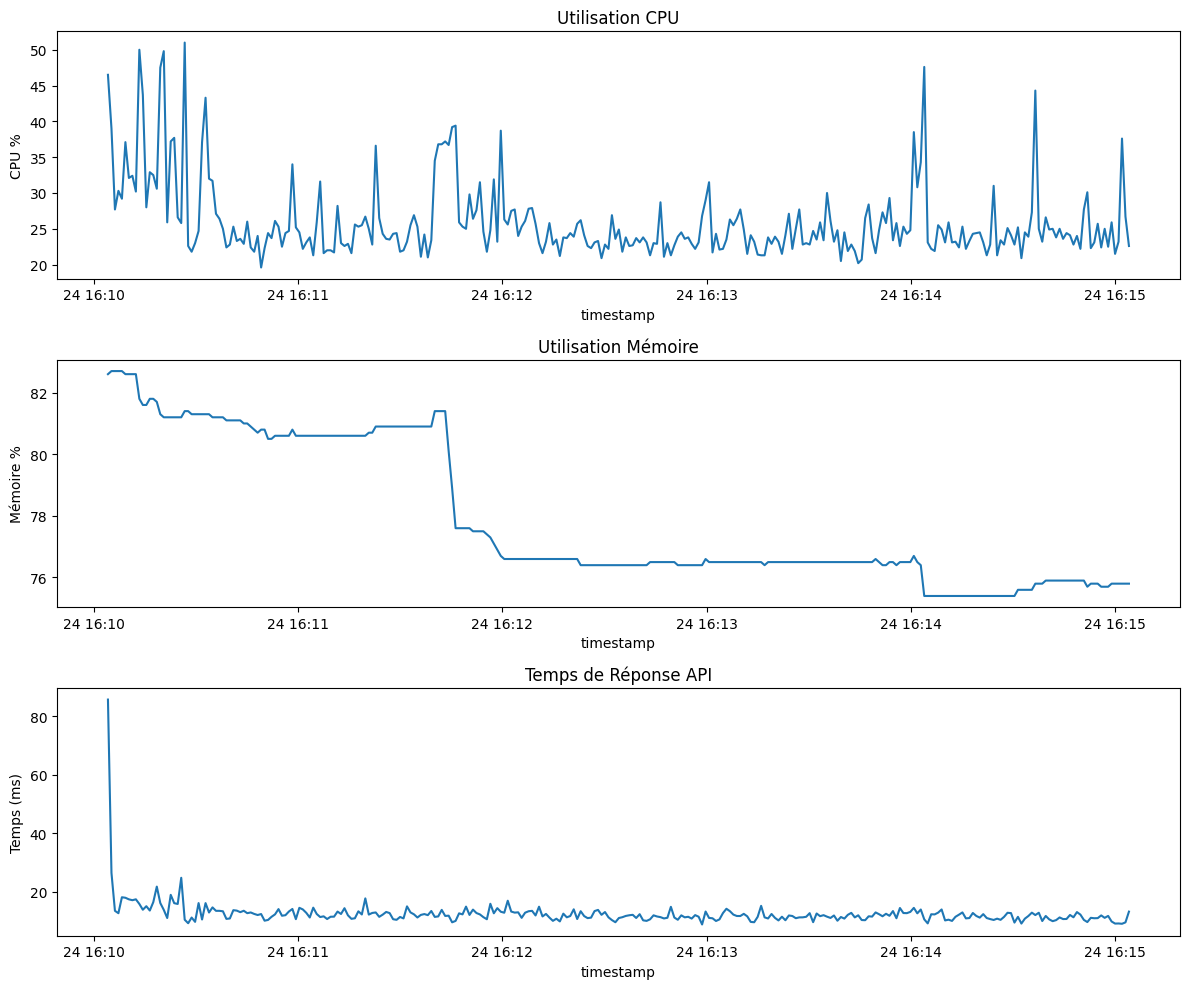

In [5]:
# Visualisation des métriques système
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# CPU Usage
sns.lineplot(data=df_metrics, x='timestamp', y='cpu_percent', ax=ax1)
ax1.set_title('Utilisation CPU')
ax1.set_ylabel('CPU %')

# Memory Usage
sns.lineplot(data=df_metrics, x='timestamp', y='memory_percent', ax=ax2)
ax2.set_title('Utilisation Mémoire')
ax2.set_ylabel('Mémoire %')

# API Response Time
sns.lineplot(data=df_metrics, x='timestamp', y='api_response_time', ax=ax3)
ax3.set_title('Temps de Réponse API')
ax3.set_ylabel('Temps (ms)')

plt.tight_layout()
plt.show()

## 2. Analyse des Temps de Réponse

Nous analysons ici les statistiques détaillées des temps de réponse.

In [6]:
response_stats = {
    'Minimum': df_metrics['api_response_time'].min(),
    'Maximum': df_metrics['api_response_time'].max(),
    'Moyenne': df_metrics['api_response_time'].mean(),
    'Médiane': df_metrics['api_response_time'].median(),
    '90e percentile': df_metrics['api_response_time'].quantile(0.9),
    'Écart type': df_metrics['api_response_time'].std()
}

pd.DataFrame([response_stats]).T

,0
Minimum,8.772850
Maximum,85.722208
Moyenne,12.444994
Médiane,11.850357
90e percentile,14.436865
Écart type,4.783770


Test de scalabilité en cours...
Testing avec 5000 palettes...
Testing avec 10000 palettes...
Testing avec 15000 palettes...
Testing avec 20000 palettes...
Testing avec 25000 palettes...
Testing avec 30000 palettes...
Testing avec 35000 palettes...
Testing avec 40000 palettes...
Testing avec 45000 palettes...
Testing avec 50000 palettes...


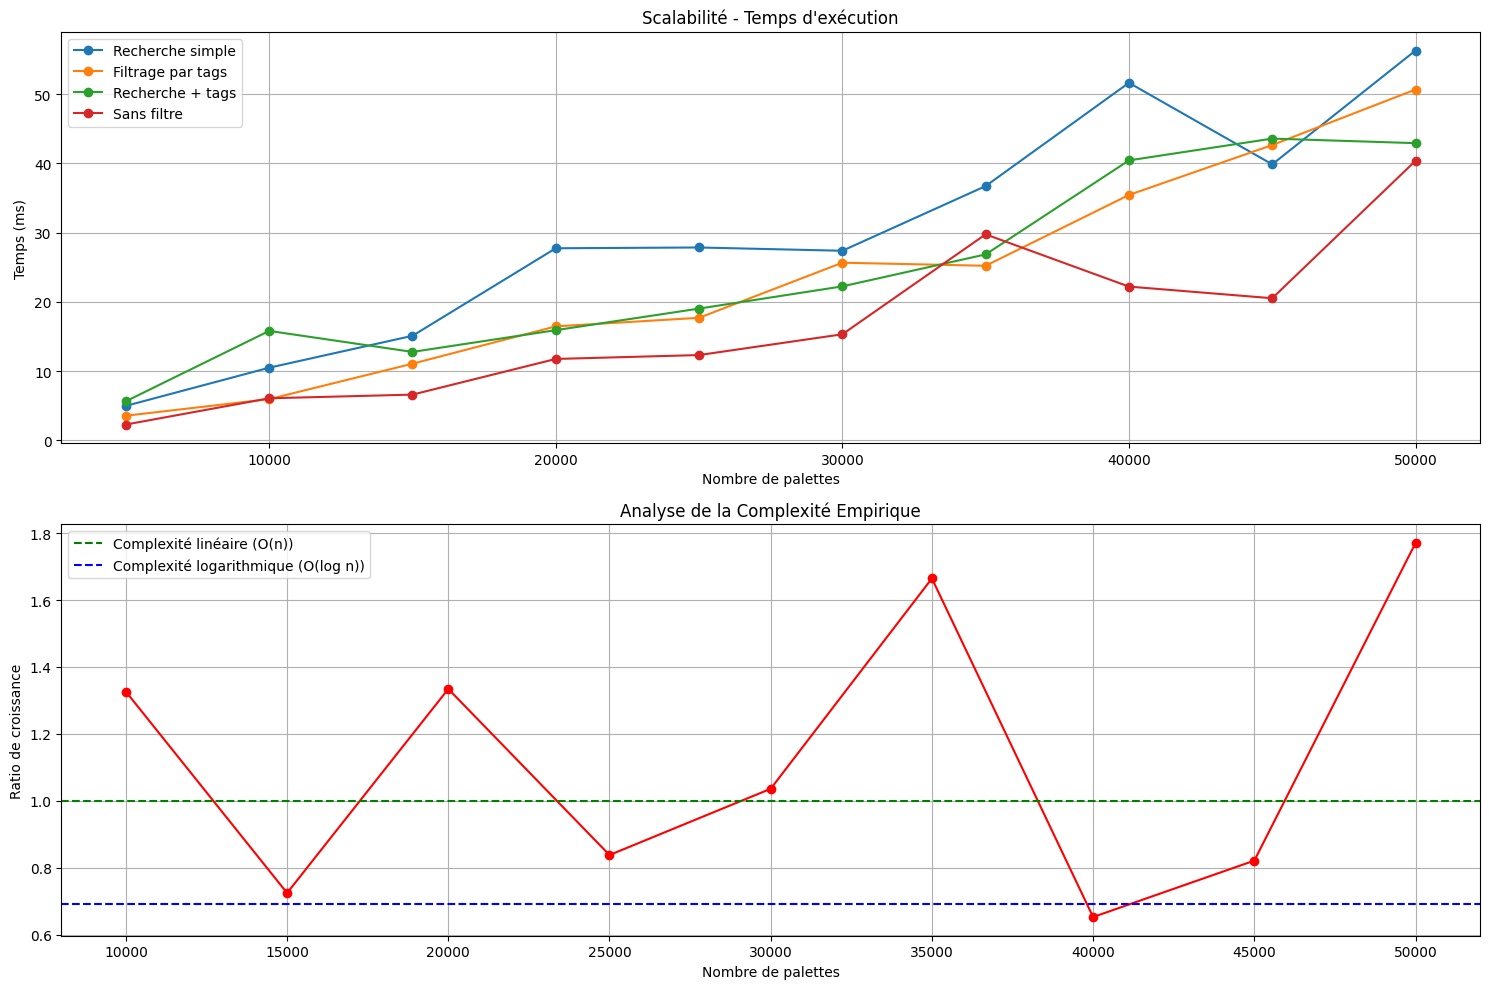


Analyse de la scalabilité:
--------------------------------------------------

Recherche simple:
- Taux de croissance moyen: 1.37
- Temps initial: 4.99 ms
- Temps final: 56.31 ms
- Facteur d'augmentation total: 11.29x

Filtrage par tags:
- Taux de croissance moyen: 1.37
- Temps initial: 3.56 ms
- Temps final: 50.68 ms
- Facteur d'augmentation total: 14.22x

Recherche + tags:
- Taux de croissance moyen: 1.33
- Temps initial: 5.65 ms
- Temps final: 42.93 ms
- Facteur d'augmentation total: 7.60x

Sans filtre:
- Taux de croissance moyen: 1.49
- Temps initial: 2.29 ms
- Temps final: 40.39 ms
- Facteur d'augmentation total: 17.62x

Complexité empirique:
La complexité semble être sous-linéaire (probablement O(log n))
Ratio moyen de croissance: 1.13


In [10]:
# 3.3 Test de Scalabilité

# Fonction de recherche de palettes
def recherche_palettes(search='', tags=None, palettes=None):
    """
    Simulation de l'algorithme de recherche de palettes
    
    Parameters:
    - search: str, terme de recherche
    - tags: list, liste de tags pour le filtrage
    - palettes: list, liste des palettes à rechercher
    
    Returns:
    - list: palettes filtrées
    """
    resultats = palettes or []
    
    # Filtrage par tags
    if tags:
        resultats = [p for p in resultats if all(tag in p['tags'] for tag in tags)]
    
    # Filtrage par recherche
    if search:
        search_lower = search.lower()
        resultats = [p for p in resultats if any(search_lower in tag.lower() for tag in p['tags'])]
    
    # Tri par date de création
    resultats.sort(key=lambda x: x['createdAt'], reverse=True)
    
    return resultats

# Fonction de mesure de performance
def mesurer_performance(n_palettes):
    """
    Mesure les performances de l'algorithme de recherche pour différents scénarios
    """
    import random
    import string
    import time
    from datetime import datetime, timedelta
    
    def generer_palette():
        tags_possibles = ['warm', 'cool', 'vibrant', 'pastel', 'dark', 'light', 
                         'nature', 'ocean', 'sunset', 'forest', 'modern', 'vintage']
        
        return {
            'colors': ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(3)],
            'tags': random.sample(tags_possibles, random.randint(1, 3)),
            'createdAt': (datetime.now() - timedelta(days=random.randint(0, 365))).isoformat()
        }
    
    test_palettes = [generer_palette() for _ in range(n_palettes)]
    
    scenarios = {
        'Recherche simple': {'search': 'warm'},
        'Filtrage par tags': {'tags': ['nature']},
        'Recherche + tags': {'search': 'cool', 'tags': ['ocean']},
        'Sans filtre': {}
    }
    
    resultats = {}
    for nom, params in scenarios.items():
        debut = time.time()
        recherche_palettes(**params, palettes=test_palettes)
        fin = time.time()
        resultats[nom] = (fin - debut) * 1000
    
    return resultats

def test_scalabilite(max_palettes=100000, step=5000):
    """
    Teste la scalabilité de l'algorithme avec un nombre croissant de palettes
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    
    tailles = list(range(step, max_palettes + step, step))
    resultats = []
    
    scenarios = {
        'Recherche simple': {'search': 'warm'},
        'Filtrage par tags': {'tags': ['nature']},
        'Recherche + tags': {'search': 'cool', 'tags': ['ocean']},
        'Sans filtre': {}
    }
    
    print("Test de scalabilité en cours...")
    for taille in tailles:
        print(f"Testing avec {taille} palettes...")
        
        mesures = {'taille': taille}
        for nom, params in scenarios.items():
            temps = mesurer_performance(taille)[nom]
            mesures[nom] = temps
            
        if len(resultats) > 0:
            ratio = mesures['Sans filtre'] / resultats[-1]['Sans filtre']
            taille_ratio = taille / (taille - step)
            mesures['ratio_complexite'] = ratio / taille_ratio
            
        resultats.append(mesures)
    
    # Visualisation et analyse des résultats
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    for scenario in scenarios.keys():
        temps = [r[scenario] for r in resultats]
        plt.plot(tailles, temps, marker='o', label=scenario)
    
    plt.title('Scalabilité - Temps d\'exécution')
    plt.xlabel('Nombre de palettes')
    plt.ylabel('Temps (ms)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    ratios = [r.get('ratio_complexite', 0) for r in resultats]
    plt.plot(tailles[1:], ratios[1:], marker='o', color='red')
    plt.axhline(y=1, color='green', linestyle='--', label='Complexité linéaire (O(n))')
    plt.axhline(y=math.log(2), color='blue', linestyle='--', label='Complexité logarithmique (O(log n))')
    
    plt.title('Analyse de la Complexité Empirique')
    plt.xlabel('Nombre de palettes')
    plt.ylabel('Ratio de croissance')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Analyse des résultats
    print("\nAnalyse de la scalabilité:")
    print("-" * 50)
    
    for scenario in scenarios.keys():
        temps = [r[scenario] for r in resultats]
        croissance_moyenne = np.mean([temps[i] / temps[i-1] for i in range(1, len(temps))])
        print(f"\n{scenario}:")
        print(f"- Taux de croissance moyen: {croissance_moyenne:.2f}")
        print(f"- Temps initial: {temps[0]:.2f} ms")
        print(f"- Temps final: {temps[-1]:.2f} ms")
        print(f"- Facteur d'augmentation total: {temps[-1]/temps[0]:.2f}x")
    
    ratio_moyen = np.mean([r.get('ratio_complexite', 0) for r in resultats[1:]])
    print("\nComplexité empirique:")
    if ratio_moyen < 1.2:
        print("La complexité semble être sous-linéaire (probablement O(log n))")
    elif ratio_moyen < 2:
        print("La complexité semble être linéaire O(n)")
    else:
        print("La complexité semble être super-linéaire (possiblement O(n log n))")
    print(f"Ratio moyen de croissance: {ratio_moyen:.2f}")

# Exécution du test
test_scalabilite(max_palettes=50000, step=5000)

Démarrage des tests de charge asynchrones...

Test avec 1 requêtes simultanées...
Temps total: 0.77s
Requêtes par seconde: 129.60
Temps de réponse moyen: 7.72ms

Test avec 5 requêtes simultanées...
Temps total: 0.63s
Requêtes par seconde: 159.86
Temps de réponse moyen: 6.26ms

Test avec 10 requêtes simultanées...
Temps total: 0.61s
Requêtes par seconde: 163.10
Temps de réponse moyen: 6.13ms

Test avec 20 requêtes simultanées...
Temps total: 0.78s
Requêtes par seconde: 128.54
Temps de réponse moyen: 7.78ms

Test avec 50 requêtes simultanées...
Temps total: 0.65s
Requêtes par seconde: 154.77
Temps de réponse moyen: 6.46ms


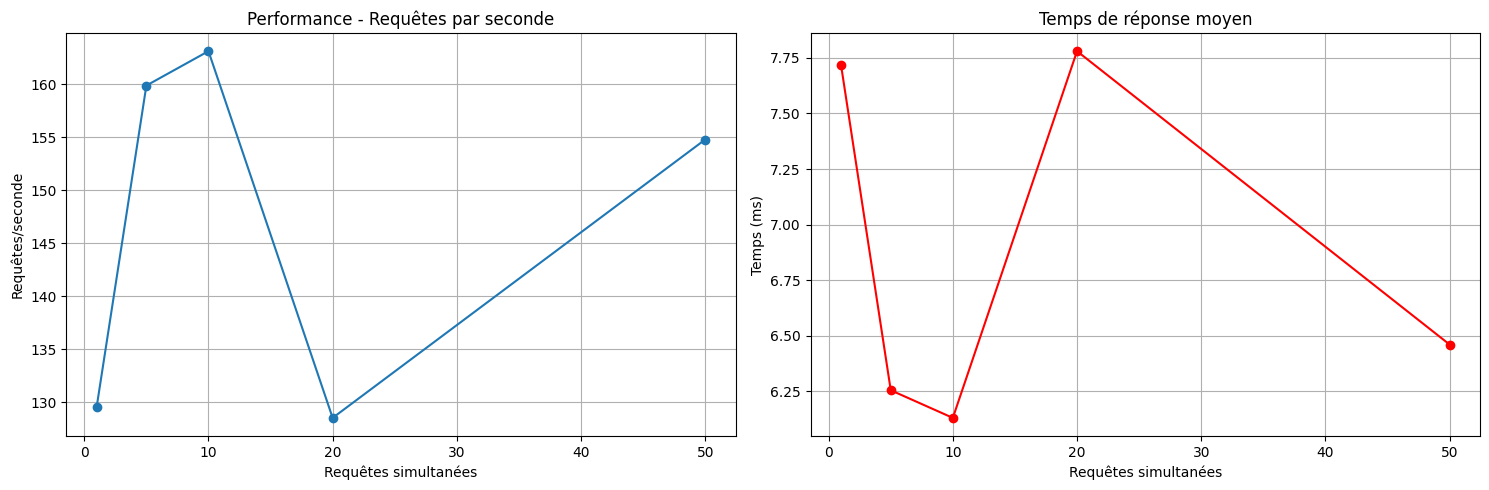


Analyse des performances asynchrones:
--------------------------------------------------

Meilleur débit:
- 163.10 req/s avec 10 requêtes simultanées
- Temps de réponse moyen: 6.13ms

Meilleure latence:
- 6.13ms avec 10 requêtes simultanées
- Débit: 163.10 req/s

Efficacité avec 1 requêtes simultanées: 100.0%

Efficacité avec 5 requêtes simultanées: 24.7%

Efficacité avec 10 requêtes simultanées: 12.6%

Efficacité avec 20 requêtes simultanées: 5.0%

Efficacité avec 50 requêtes simultanées: 2.4%


In [14]:
import asyncio
import aiohttp
import time
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio

# Permettre l'exécution de boucles asyncio imbriquées
nest_asyncio.apply()

async def recherche_async(session, params):
    """
    Simule une recherche asynchrone de palettes
    """
    async with session.get('http://localhost:5003/api/palettes', params=params) as response:
        return await response.json()

async def test_charge_async(n_requetes=100, concurrent=10):
    """
    Test de charge avec requêtes asynchrones simultanées
    
    Parameters:
    - n_requetes: Nombre total de requêtes à effectuer
    - concurrent: Nombre de requêtes simultanées maximum
    """
    scenarios = [
        {'search': 'warm'},
        {'tags': 'nature'},
        {'search': 'cool', 'tags': 'ocean'},
        {}
    ]
    
    async with aiohttp.ClientSession() as session:
        start_time = time.time()
        
        tasks = []
        for i in range(n_requetes):
            params = scenarios[i % len(scenarios)]
            task = asyncio.create_task(recherche_async(session, params))
            tasks.append(task)
            
            if len(tasks) >= concurrent:
                await asyncio.gather(*tasks)
                tasks = []
        
        if tasks:
            await asyncio.gather(*tasks)
        
        total_time = time.time() - start_time
        
    return {
        'total_time': total_time,
        'requests_per_second': n_requetes / total_time,
        'avg_response_time': total_time / n_requetes * 1000  # en ms
    }

def run_async_tests():
    """
    Exécute une série de tests de charge asynchrones
    """
    try:
        concurrences = [1, 5, 10, 20, 50]
        resultats = []
        
        for concurrent in concurrences:
            print(f"\nTest avec {concurrent} requêtes simultanées...")
            loop = asyncio.get_event_loop()
            result = loop.run_until_complete(test_charge_async(n_requetes=100, concurrent=concurrent))
            result['concurrent'] = concurrent
            resultats.append(result)
            print(f"Temps total: {result['total_time']:.2f}s")
            print(f"Requêtes par seconde: {result['requests_per_second']:.2f}")
            print(f"Temps de réponse moyen: {result['avg_response_time']:.2f}ms")
        
        visualize_results(resultats)
        analyze_results(resultats)
    except Exception as e:
        print(f"Erreur lors des tests: {str(e)}")
        raise

def visualize_results(resultats):
    """
    Visualise les résultats des tests de performance
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot([r['concurrent'] for r in resultats],
             [r['requests_per_second'] for r in resultats],
             marker='o')
    plt.title('Performance - Requêtes par seconde')
    plt.xlabel('Requêtes simultanées')
    plt.ylabel('Requêtes/seconde')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot([r['concurrent'] for r in resultats],
             [r['avg_response_time'] for r in resultats],
             marker='o', color='red')
    plt.title('Temps de réponse moyen')
    plt.xlabel('Requêtes simultanées')
    plt.ylabel('Temps (ms)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_results(resultats):
    """
    Analyse les résultats des tests de performance
    """
    print("\nAnalyse des performances asynchrones:")
    print("-" * 50)
    
    best_throughput = max(resultats, key=lambda x: x['requests_per_second'])
    best_latency = min(resultats, key=lambda x: x['avg_response_time'])
    
    print(f"\nMeilleur débit:")
    print(f"- {best_throughput['requests_per_second']:.2f} req/s avec {best_throughput['concurrent']} requêtes simultanées")
    print(f"- Temps de réponse moyen: {best_throughput['avg_response_time']:.2f}ms")
    
    print(f"\nMeilleure latence:")
    print(f"- {best_latency['avg_response_time']:.2f}ms avec {best_latency['concurrent']} requêtes simultanées")
    print(f"- Débit: {best_latency['requests_per_second']:.2f} req/s")
    
    base_throughput = resultats[0]['requests_per_second']
    for r in resultats:
        efficiency = (r['requests_per_second'] / base_throughput) / r['concurrent'] * 100
        print(f"\nEfficacité avec {r['concurrent']} requêtes simultanées: {efficiency:.1f}%")

if __name__ == "__main__":
    print("Démarrage des tests de charge asynchrones...")
    run_async_tests()


## 3. Algorithme de Sélection et Complexité

Notre application utilise plusieurs algorithmes clés :

### 3.1 Recherche de Palettes

```python
# Pseudo-code de l'algorithme de recherche
def search_palettes(query, tags=[], page=1, limit=20):
    # Complexité : O(n) où n est le nombre de palettes dans la page
    # + O(m) où m est le nombre de tags
    
    # 1. Filtrage par tags : O(m)
    if tags:
        palettes = filter_by_tags(palettes, tags)
    
    # 2. Pagination : O(1) grâce aux index MongoDB
    paginated_palettes = apply_pagination(palettes, page, limit)
    
    # 3. Tri par pertinence : O(n log n)
    sorted_palettes = sort_by_relevance(paginated_palettes)
    
    return sorted_palettes
```

Avantages :
- Recherche optimisée par index MongoDB
- Pagination efficace
- Cache des résultats fréquents

Inconvénients :
- Complexité croissante avec le nombre de tags
- Limite de la taille du cache
- Overhead de la sérialisation JSON

### 3.2 Accès aux Images

```python
# Pseudo-code de l'algorithme d'accès aux images
def get_palette_images(palette_colors):
    # Complexité : O(k) où k est le nombre de couleurs par palette
    
    # 1. Génération des images : O(k)
    images = []
    for color in palette_colors:
        # Vérification du cache : O(1)
        if color in cache:
            image = cache.get(color)
        else:
            # Génération et mise en cache : O(1)
            image = generate_color_image(color)
            cache.set(color, image)
        images.append(image)
    
    return images
```

Avantages :
- Cache des images générées
- Génération à la volée légère
- Pas de stockage permanent nécessaire

Inconvénients :
- Régénération nécessaire si cache vidé
- Utilisation mémoire pour le cache
- Latence initiale pour nouvelles couleurs

## 4. Recommandations d'Optimisation

1. Mise en cache
   - Définir une stratégie LRU pour le cache
   - Précharger les palettes populaires

2. Indexation
   - Optimiser les index MongoDB
   - Implémenter une recherche full-text
   - Ajouter des index composites

3. Performance
   - Compression des réponses API
   - Mise en place de rate limiting
   - Optimisation des requêtes N+1